In [ ]:
import os
os.environ["MUJOCO_GL"] = "egl"
import mujoco
import numpy as np
import onnxruntime as rt


import mediapy

np.set_printoptions(precision=3, suppress=True, linewidth=500)
# Constants
_ARM_JOINTS = ["joint1", "joint2", "joint3", "joint4", "joint5", "joint6"]
_FINGER_JOINTS = ["endleft", "endright"]
XML_PATH = "xmls/mjx_single_cube.xml"
ONNX_PATH = "/root/data/code/junzhe/mj2/mujoco_playground/mujoco_playground/experimental/sim2sim/onnx/airbot_state_ppo603.onnx"
#ONNX_PATH = "/root/data/code/junzhe/mj2/mujoco_playground/mujoco_playground/experimental/sim2sim/onnx/airbot_state_ppo601.onnx"

In [13]:
class AirbotPlayController:
    def __init__(self, model, data, policy_path):
        self.model = model
        self.data = data
        self.policy = rt.InferenceSession(policy_path, providers=["CPUExecutionProvider"])
        self.output_names = [self.policy.get_outputs()[0].name]
        self.input_name = self.policy.get_inputs()[0].name
        
        # IDs
        self.gripper_site_id = model.site("endpoint").id
        self.obj_body_id = model.body("box").id
        self.mocap_target_id = model.body("mocap_target").mocapid[0]
        
        # Joint indices
        all_joints = _ARM_JOINTS + _FINGER_JOINTS
        self.robot_qpos_adr = np.array([model.jnt_qposadr[model.joint(j).id] for j in all_joints])
        
        # Config
        self.action_scale = 0.04
        
    def get_obs(self):
        data = self.data
        
        gripper_pos = data.site_xpos[self.gripper_site_id]
        gripper_mat = data.site_xmat[self.gripper_site_id].reshape(9)
        
        mocap_quat = data.mocap_quat[self.mocap_target_id]
        target_mat = np.zeros(9)
        mujoco.mju_quat2Mat(target_mat, mocap_quat)
        
        obj_xmat = data.xmat[self.obj_body_id].reshape(9)
        obj_xpos = data.xpos[self.obj_body_id]
        
        target_pos = data.mocap_pos[self.mocap_target_id]
        
        # data.ctrl corresponds to actuators. 
        # The observation uses data.qpos[self._robot_qposadr[:-1]] which is 7 elements.
        qpos_ref = data.qpos[self.robot_qpos_adr[:-1]]
        
        obs = np.concatenate([
            data.qpos[self.robot_qpos_adr], # 15
            data.qvel[self.robot_qpos_adr], # 14
            gripper_pos, # 3
            gripper_mat[3:], # 6
            obj_xmat[3:], # 6
            obj_xpos - gripper_pos, # 3
            target_pos - obj_xpos, # 3
            target_mat[:6] - obj_xmat[:6], # 6
            data.ctrl - qpos_ref # 7
        ])
        return obs.astype(np.float32)

    def step(self):
        obs = self.get_obs()
        input_data = {self.input_name: obs.reshape(1, -1)}
        action = self.policy.run(self.output_names, input_data)[0][0]
        
        # Apply action
        delta = action * self.action_scale
        self.data.ctrl[:] = self.data.ctrl + delta
        
        # Clip control
        ctrl_range = self.model.actuator_ctrlrange
        self.data.ctrl[:] = np.clip(self.data.ctrl, ctrl_range[:, 0], ctrl_range[:, 1])
        
        return action
        
    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        
        # Reset to "home" keyframe
        keyframe_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_KEY, "home")
        if keyframe_id >= 0:
            mujoco.mj_resetDataKeyframe(self.model, self.data, keyframe_id)
            self.data.ctrl[:] = self.model.keyframe("home").ctrl
        else:
            print("Warning: 'home' keyframe not found, using default reset")
            
        # Randomize box position (simple version)
        # In pick.py: box_pos = uniform([-0.1, -0.1, 0.0], [0.1, 0.1, 0.0]) + init_obj_pos
        # We can just add some noise to the box qpos
        obj_qpos_adr = self.model.jnt_qposadr[self.model.body("box").jntadr[0]]
        self.data.qpos[obj_qpos_adr:obj_qpos_adr+2] += np.random.uniform(-0.1, 0.1, size=2)
        
        # Randomize target position
        # In pick.py: target_pos = uniform([-0.1, -0.1, 0.1], [0.1, 0.1, 0.2]) + init_obj_pos
        # We update mocap pos
        init_obj_pos = self.model.keyframe("home").qpos[obj_qpos_adr:obj_qpos_adr+3]
        target_offset = np.random.uniform([-0.1, -0.1, 0.1], [0.1, 0.1, 0.2])
        self.data.mocap_pos[self.mocap_target_id] = init_obj_pos + target_offset
        
        mujoco.mj_forward(self.model, self.data)

In [14]:
# Load model
if not os.path.exists(XML_PATH):
    raise FileNotFoundError(f"XML file not found: {XML_PATH}")
if not os.path.exists(ONNX_PATH):
    raise FileNotFoundError(f"ONNX file not found: {ONNX_PATH}")

model = mujoco.MjModel.from_xml_path(XML_PATH)
data = mujoco.MjData(model)

# Initialize controller
controller = AirbotPlayController(model, data, ONNX_PATH)
controller.reset()

# Simulation parameters
ctrl_dt = 0.02
sim_dt = 0.005
n_substeps = int(ctrl_dt / sim_dt)
model.opt.timestep = sim_dt

camera = "side"
fps = 30
scene_option = mujoco.MjvOption()
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
renderer = mujoco.Renderer(model, height=480, width=640)
print("Starting simulation...")

frames = []
log_history = []
while data.time < 3.0:
    renderer.update_scene(data, camera=camera, scene_option=scene_option)
    img = renderer.render()

    # Control step
    action = controller.step()
    log_history.append({
        "time": data.time,
        "action": action.copy(),
        "jq" : data.qpos[controller.robot_qpos_adr].copy()
    })

    # Physics steps
    for _ in range(n_substeps):
        mujoco.mj_step(model, data)

    if len(frames) < data.time * fps:
        frames.append(img)

mediapy.show_video(frames, fps=fps)

Starting simulation...


: 

[]

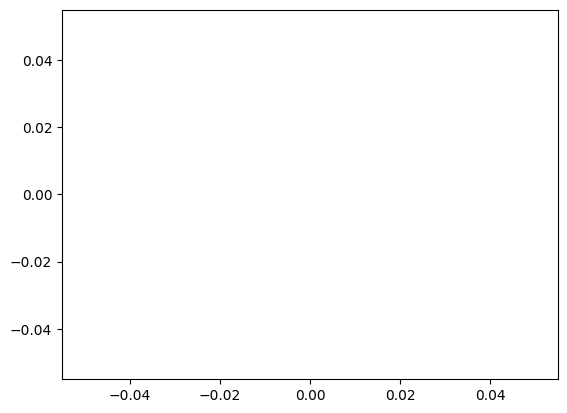

In [15]:
import matplotlib.pyplot as plt

log_history_clip = [entry for entry in log_history[:30]]
times = np.array([entry["time"] for entry in log_history_clip])
actions = np.array([entry["action"] for entry in log_history_clip])
jq = np.array([entry["jq"] for entry in log_history_clip])

plt.plot(times, jq[:, 8:])

# plt.plot(times, actions[:, 6])
# plt.plot(times, jq[:, 6], label='6')
# plt.plot(times, jq[:, 7], label='7')
# plt.legend()
# plt.plot(times, actions[:, :6])

In [ ]:
print(data.qpos.shape)
print(data.qpos)

(15,)
[ 0.467 -0.717  0.059  0.326 -0.61  -0.604  0.013  0.009  0.314 -0.04   0.015  0.706  0.031  0.706 -0.03 ]


: 

In [ ]:
controller.robot_qpos_adr

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

: 

: 